In [1]:
#cd to the script folder
from google.colab import drive
import os
import sys
import gdown

drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Hackathon/DTM') #Need to change the address to where your script is
os.listdir('.')

Mounted at /content/drive


['DTMicroscope',
 'test_data',
 'model.keras',
 '__pycache__',
 'DTM_test.ipynb',
 'segmentation_function.py',
 'iterativeclustering.py',
 'Contour_analysis.py']

In [7]:
'''download necessary data and packages'''
!git clone https://github.com/pycroscopy/DTMicroscope.git                                                                  #DTM
gdown.download_folder('https://drive.google.com/drive/folders/17F3iXxnb5I5tktyEW_et5iK9yJGhU_Lj?usp=sharing', quiet=True)  #dataset
gdown.download('https://drive.google.com/uc?id=1UQnigKw8o7psh3oIhRATAy4FNXTkbldL', quiet=True)                             #model#

fatal: destination path 'DTMicroscope' already exists and is not an empty directory.


'model.keras'

In [2]:
'''Instal packages'''
os.chdir('/content/drive/My Drive/Hackathon/DTM/DTMicroscope')
!pip install .
os.chdir('/content/drive/My Drive/Hackathon/DTM')
sys.path.insert(0, '/content/drive/My Drive/Hackathon/DTM/DTMicroscope')

##The installation above sounds stupid and complicated. Is there a better way to install it?

!pip install SciFiReaders

Processing /content/drive/My Drive/Hackathon/DTM/DTMicroscope
  Preparing metadata (setup.py) ... done
  Created wheel for DTMicroscope: filename=DTMicroscope-0.0.1-py3-none-any.whl size=27886 sha256=a514909bdad17aec85c6586a52bc031b507eb5c04e6cda2dc3b568a70f670004
  Stored in directory: /tmp/pip-ephem-wheel-cache-jzevfirt/wheels/c2/90/14/05d0cd62fbb15668bd027cacf75a5db8d070508ad84280c10e
Successfully built DTMicroscope
  Attempting uninstall: DTMicroscope
    Found existing installation: DTMicroscope 0.0.1
    Uninstalling DTMicroscope-0.0.1:
      Successfully uninstalled DTMicroscope-0.0.1


In [23]:
import SciFiReaders
from DTMicroscope.base import BaseMicroscope
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
from IPython.display import display, clear_output
from tensorflow.keras.models import load_model
import Contour_analysis
import segmentation_function
import iterativeclustering

class TEM(BaseMicroscope):
  """I rewrote a new BaseMicroscope class for TEM data"""
  def __init__(self, data_path = None) -> None:
    super().__init__(data_path=data_path)
    #self._load_dataset_ram()

  def _sort_datasets(self):
      self.data_dict = glob(self.data_path + '*.dm4')

  def _load_dataset_ram(self):
      self.dataset = []
      for file in self.data_dict:
        reader = SciFiReaders.DM3Reader(file)
        self.dataset.append(reader.read())
      return

def split_image(image):
    """
    Splits a (2048, 2048) numpy array into 16 (512, 512) sub-images.

    Parameters:
        image (numpy.ndarray): Input image of shape (2048, 2048), dtype=float.

    Returns:
        numpy.ndarray: Array of shape (16, 512, 512), dtype=float, containing the sub-images.
    """
    if image.shape != (2048, 2048):
        raise ValueError("Input image must have shape (2048, 2048).")
    image = image.astype(np.float32)
    lb = np.percentile(image,0.8)
    ub = np.percentile(image,99.2)
    image = (image - lb) / (ub - lb)
    image[image < 0] = 0
    image[image > 1] = 1
    image = cv2.GaussianBlur(image, ksize=(0, 0), sigmaX=2, sigmaY=2)
    # Initialize output array to store 16 (512, 512) images
    sub_images = np.zeros((16, 512, 512), dtype=image.dtype)

    # Split the image into 512x512 chunks
    idx = 0
    for i in range(0, 2048, 512):
        for j in range(0, 2048, 512):
            sub_images[idx] = image[i:i+512, j:j+512]
            idx += 1
    return sub_images

def stitch_images(sub_images):
  image = np.zeros((2048,2048))
  idx = 0
  for i in range(0, 2048, 512):
    for j in range(0, 2048, 512):
      image[i:i+512, j:j+512] = np.argmax(sub_images[idx],axis = 2)
      idx += 1
  return image

def get_stats(analyzer_results):
  areas = np.array([x['area'] for x in analyzer_results])
  aspect_ratio = np.array([x['aspect_ratio'] for x in analyzer_results])
  eccentricity = np.array([x['eccentricity'] for x in analyzer_results])
  circularity = np.array([x['circularity'] for x in analyzer_results])
  return np.stack((areas,aspect_ratio,eccentricity,circularity),axis = 1)

def filter(analyzer_results):
  convexity = np.array([x['convexity'] for x in analyzer_results])
  solidity = np.array([x['solidity'] for x in analyzer_results])
  mask = np.logical_and(convexity>0.9, solidity>0.95)
  return np.array(analyzer_results)[mask].tolist(), mask

In [4]:
model = load_model('model.keras')
M = TEM("test_data/")
M._load_dataset_ram()

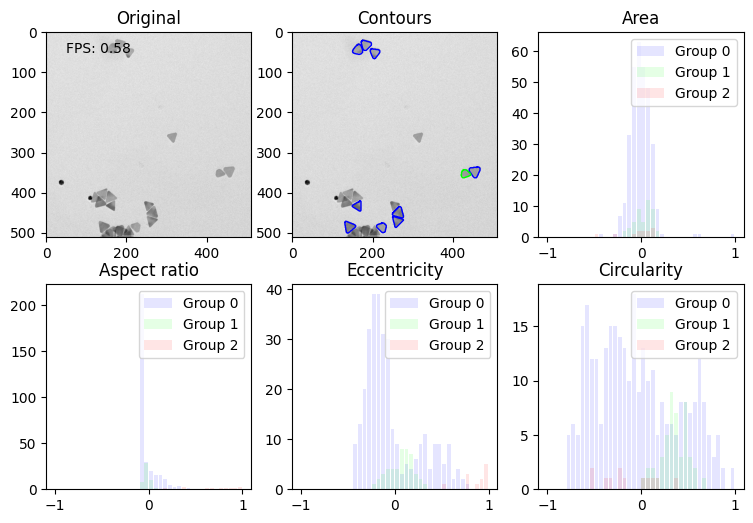

In [24]:
np.seterr(all="ignore")
analyzer = Contour_analysis.ContourAnalyzer()
iterativecluster = iterativeclustering.iterativeclustering()
t0 = time.time()
color = np.concatenate((np.expand_dims(np.array([0,0,1]), axis = 0), np.expand_dims(np.array([0,1,0]), axis = 0), np.expand_dims(np.array([1,0,0]), axis = 0) , np.random.rand(10,3)), axis = 0)
binE = np.arange(-1,1.05,0.05)
binC = (binE[:-1]+binE[1:])/2

for itr in range(30):
  '''this for loop mimics the continous viewing mode on TEM'''

  data = M.dataset[np.mod(itr,len(M.dataset))]
  t = time.time()
  data_np = data['Channel_000'].compute()
  data_np = cv2.resize(data_np,(2048,2048))
  data_fplot = cv2.resize(data_np,(512,512))

  '''make predictions'''
  data_sub = split_image(data_np)
  predictions = model.predict(data_sub, batch_size=1, verbose=0)
  data_pred = stitch_images(predictions)
  Bs = segmentation_function.process_image(data_pred/2*255)
  N = len(Bs)

  '''do some statistic'''
  for B in Bs:
    analyzer.all_properties.append(analyzer.analyze_single_contour(B))
  results_filtered, mask = filter(analyzer.all_properties)
  Bs = Bs[mask[-N:]]

  stats = get_stats(results_filtered)
  stats_norm = iterativecluster.norm(stats)

  '''do clustering'''
  opt_results, step_results = iterativecluster.iterativeclustering(stats_norm, 3)
  label = opt_results["classes"]
  valuesA = []; valuesB = []; valuesC = []; valuesD = []
  for i in range(np.max(label)+1):
    value,_ = np.histogram(stats_norm[label==i,0], bins= binE)
    valuesA.append(value)
    value,_ = np.histogram(stats_norm[label==i,1], bins= binE)
    valuesB.append(value)
    value,_ = np.histogram(stats_norm[label==i,2], bins= binE)
    valuesC.append(value)
    value,_ = np.histogram(stats_norm[label==i,3], bins= binE)
    valuesD.append(value)

  '''plotting'''
  f,axs = plt.subplots(2,3, figsize = (9,6))
  axs[0][0].imshow(data_fplot,cmap = 'gray')
  axs[0][0].set_title('Original')
  axs[0][0].text(50,50,'FPS: ' + '{:.2f}'.format(1/(t-t0)))

  axs[0][1].imshow(data_fplot,cmap = 'gray')

  itr = 0
  for B in Bs:
    axs[0][1].plot(np.concatenate((B[:,0],B[:2,0])),np.concatenate((B[:,1],B[:2,1])), linewidth = 1, color = color[label[itr],:])
    itr += 1
  axs[0][1].set_title('Contours')

  for i in range(np.max(label)+1):
    axs[0][2].bar(binC, valuesA[i], color = color[i,:], width=0.04, alpha = 0.1)
    axs[1][0].bar(binC, valuesB[i], color = color[i,:], width=0.04, alpha = 0.1)
    axs[1][1].bar(binC, valuesC[i], color = color[i,:], width=0.04, alpha = 0.1)
    axs[1][2].bar(binC, valuesD[i], color = color[i,:], width=0.04, alpha = 0.1)

  axs[0][2].set_title('Area')
  axs[0][2].legend(labels=['Group ' + str(x) for x in range(np.max(label)+1)])
  axs[0][2].set_box_aspect(1)

  axs[1][0].set_title('Aspect ratio')
  axs[1][0].legend(labels=['Group ' + str(x) for x in range(np.max(label)+1)])
  axs[1][0].set_box_aspect(1)

  axs[1][1].set_title('Eccentricity')
  axs[1][1].legend(labels=['Group ' + str(x) for x in range(np.max(label)+1)])
  axs[1][1].set_box_aspect(1)

  axs[1][2].set_title('Circularity')
  axs[1][2].legend(labels=['Group ' + str(x) for x in range(np.max(label)+1)])
  axs[1][2].set_box_aspect(1)
  t0 = time.time()
  plt.show()
  time.sleep(0.1)
  clear_output(wait=True)